# Transfer learning for Few-shot Classification from the Algorithm's Perspective

Original content (this Jupyter notebook) created by Matthew McAteer([`@MatthewMcAteer0`]())

Dataset and original prompt supplied by Vinay Prabhu ([`@vinayprabhu`](https://twitter.com/vinayprabhu)) and the UnifyID Team ([`@UnifyID`](https://twitter.com/UnifyID)).

## Introduction

Transfer learning is a useful technique in machine learning. It is especially prevalent in image- and facial-recognition tasks, where training a classifier on a relatively small amount of data can be bolstered by models that have been pre-trained on larger tasks.[[1]](#scrollTo=ek-3esN_z32w)

In this demonstration, we explore the use of transfer learning (combined with random cropping for data augmentation) as a method for a few-shot classification task where the classes are extremely similar (or in our case, barely distinguishable to many humans). The random-cropping is important for ou particular analysis, as it makes the classification task more reliant on texture-classification. When using convolutional neural networks, or any network that relies on convolution filters, one is implicitly assuming Spatial Homogeneity (SH). This means the first-order statistics of the filter/neuron activations are independent of their spatial location in the image sample. This also assumes that the second-order statistics of the activations and preactivation
derivatives at any two spatial locations t and t0 depend only on t0 t. 

We will begin our workflow for transfer learning with a small dataset.

------------------------------------
# Part 1 of 2: Preparing the Data #
------------------------------------

**Since the Ginger_Tri Dataset is already available on Github, Part 1 of this notebook is entirely optional. If you are modifying the dataset, or are curious, feel free to go through this first part. Otherwise you can skip ahead to Part 2 of 2 for the model-building**

## Step 1: Download the [raw dataset](https://github.com/vinayprabhu/Ginger_3_whole_foods) 

The dataset we are going to use for transfer learning can be found in a Github repo by Vinay Prabhu. This dataset contains 3 classes: Turmeric, Ginger, and Galangal. Per the description in the [README](https://github.com/vinayprabhu/Ginger_3_whole_foods/blob/master/README.md):

>On 31st of March, 2018, I ambled in to a Whole foods paycheck store in SF and chanced upon a bunch of rhizomes of the Ginger family. They reminded me of my trip a few months ago to the [Singapore botanical garden](https://github.com/vinayprabhu/Singapore_botanic_gardens) where I had first chanced upon some other exotic little known variants of the Ginger family. I duly snapped a bunch of pics wondering if I can use these subtly different classes in a transfer learning context. 

<img src="https://github.com/vinayprabhu/Ginger_3_whole_foods/raw/master/ginger_3.png" alt="Italian Trulli" width="400" height="400">

We can download the dataset directly.

In [1]:
!wget --no-check-certificate --content-disposition https://github.com/vinayprabhu/Ginger_3_whole_foods/raw/master/ginger_tri.zip

--2019-03-03 07:57:50--  https://github.com/vinayprabhu/Ginger_3_whole_foods/raw/master/ginger_tri.zip
Resolving github.com (github.com)... 192.30.255.113, 192.30.255.112
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vinayprabhu/Ginger_3_whole_foods/master/ginger_tri.zip [following]
--2019-03-03 07:57:51--  https://raw.githubusercontent.com/vinayprabhu/Ginger_3_whole_foods/master/ginger_tri.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.40.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66519326 (63M) [application/zip]
Saving to: ‘ginger_tri.zip’

ginger_tri.zip      100%[===================>]  63.44M   392KB/s    in 34s     

2019-03-03 07:58:26 (1.88 MB/s) - ‘ginger_tri.zip’ saved [66519326/66519326]



In [2]:
!unzip ginger_tri.zip

Archive:  ginger_tri.zip
   creating: ginger_tri/
   creating: ginger_tri/Galangal/
  inflating: ginger_tri/Galangal/IMG_20180331_122745 - Copy - Copy.jpg  
  inflating: ginger_tri/Galangal/IMG_20180331_122745 - Copy.jpg  
  inflating: ginger_tri/Galangal/IMG_20180331_122745.jpg  
  inflating: ginger_tri/Galangal/IMG_20180331_122846.jpg  
   creating: ginger_tri/Ginger/
  inflating: ginger_tri/Ginger/IMG_20180331_122814 - Copy (2).jpg  
  inflating: ginger_tri/Ginger/IMG_20180331_122814 - Copy.jpg  
  inflating: ginger_tri/Ginger/IMG_20180331_122814.jpg  
  inflating: ginger_tri/Ginger/IMG_20180331_122817.jpg  
  inflating: ginger_tri/Ginger/IMG_20180331_122818.jpg  
  inflating: ginger_tri/Ginger/IMG_20180331_122820.jpg  
  inflating: ginger_tri/Ginger/IMG_20180331_122824.jpg  
  inflating: ginger_tri/Ginger/IMG_20180331_122826.jpg  
  inflating: ginger_tri/Ginger/IMG_20180331_122829.jpg  
   creating: ginger_tri/Turmeric/
  inflating: ginger_tri/Turmeric/IMG_20180331_122657 - Copy.jp

In [1]:
from PIL import Image
import os, os.path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import tensorflow as tf

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
path_galangal = "ginger_tri/Galangal"
path_ginger = "ginger_tri/Ginger"
path_turmeric = "ginger_tri/Turmeric"

valid_images = [".jpg"]

imgs_galangal = []
imgs_ginger = []
imgs_turmeric = []

for f in os.listdir(path_galangal):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    imgs_galangal.append(Image.open(os.path.join(path_galangal,f)))
    
for f in os.listdir(path_ginger):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    imgs_ginger.append(Image.open(os.path.join(path_ginger,f)))

for f in os.listdir(path_turmeric):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    imgs_turmeric.append(Image.open(os.path.join(path_turmeric,f)))
    
print("Number of Galangal images: {}".format(len(imgs_galangal)))
print("Number of Ginger images: {}".format(len(imgs_ginger)))
print("Number of Turmeric images: {}".format(len(imgs_turmeric)))

Number of Galangal images: 4
Number of Ginger images: 9
Number of Turmeric images: 8


We now have our dataset. As you can see above, there are not many files in our class folders. Let's take a closer look at these examples.

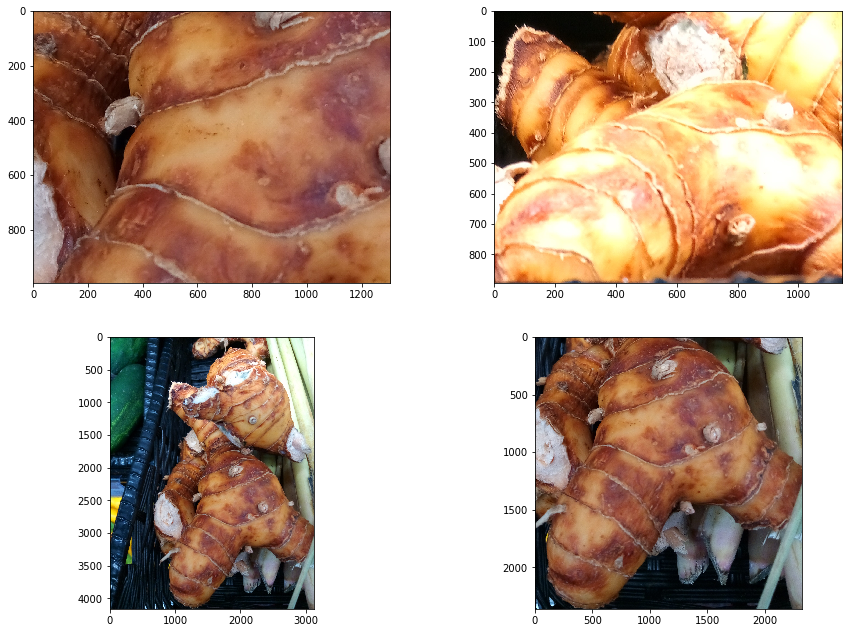

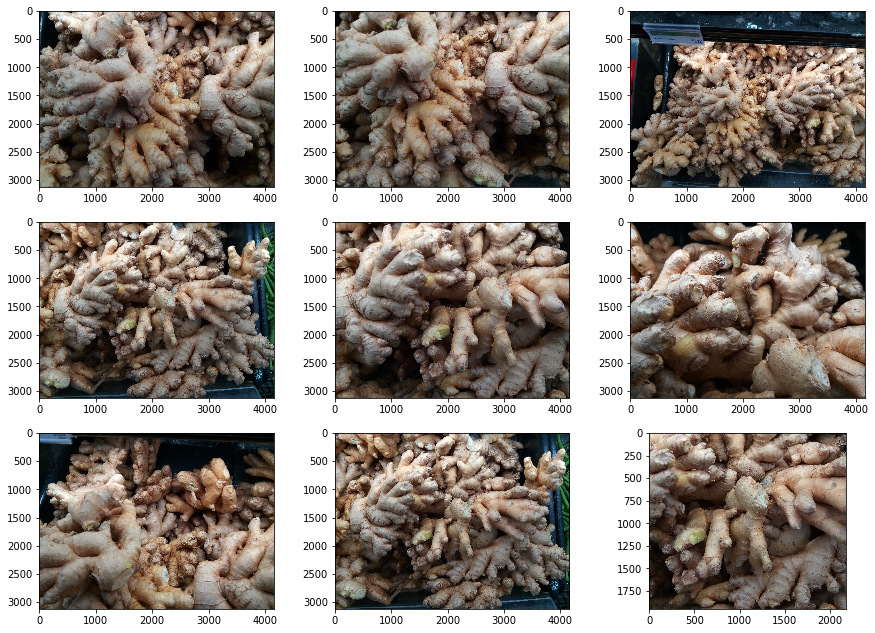

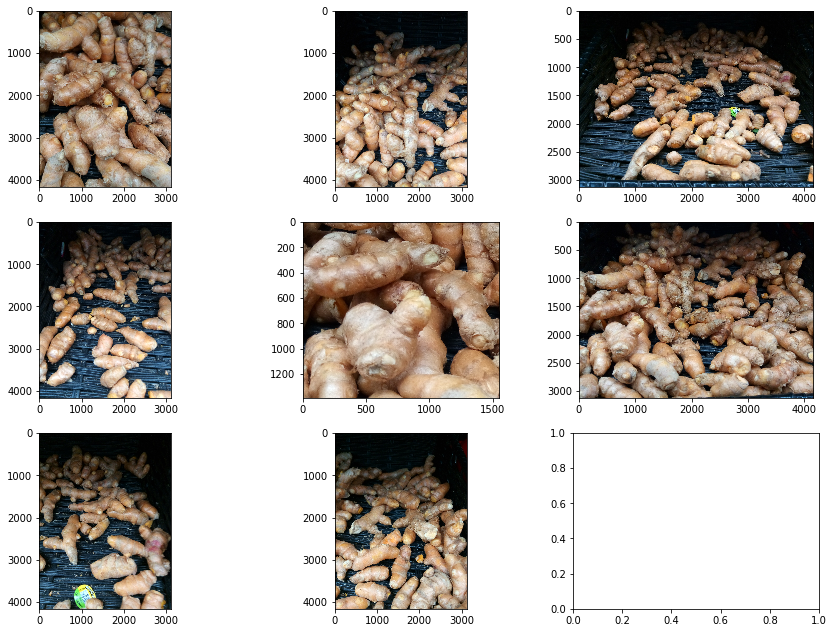

CPU times: user 7.43 s, sys: 6.02 s, total: 13.5 s
Wall time: 6.28 s


In [3]:
%%time
# Takes about 16 seconds

f, axarr = plt.subplots(2,2)
f.set_size_inches(15,11)
axarr[0,0].imshow(imgs_galangal[0])
axarr[0,1].imshow(imgs_galangal[1])
axarr[1,0].imshow(imgs_galangal[2])
axarr[1,1].imshow(imgs_galangal[3])
plt.show()

f, axarr = plt.subplots(3,3)
f.set_size_inches(15,11)
axarr[0,0].imshow(imgs_ginger[0])
axarr[0,1].imshow(imgs_ginger[1])
axarr[0,2].imshow(imgs_ginger[2])
axarr[1,0].imshow(imgs_ginger[3])
axarr[1,1].imshow(imgs_ginger[4])
axarr[1,2].imshow(imgs_ginger[5])
axarr[2,0].imshow(imgs_ginger[6])
axarr[2,1].imshow(imgs_ginger[7])
axarr[2,2].imshow(imgs_ginger[8])
plt.show()

f, axarr = plt.subplots(3,3)
f.set_size_inches(15,11)
axarr[0,0].imshow(imgs_turmeric[0])
axarr[0,1].imshow(imgs_turmeric[1])
axarr[0,2].imshow(imgs_turmeric[2])
axarr[1,0].imshow(imgs_turmeric[3])
axarr[1,1].imshow(imgs_turmeric[4])
axarr[1,2].imshow(imgs_turmeric[5])
axarr[2,0].imshow(imgs_turmeric[6])
axarr[2,1].imshow(imgs_turmeric[7])
plt.show()

del f

This represents the entirety of our current dataset. While these images are high resolution, they are insufficient for most neural networks (although perhaps appropriate for a support vector machine). For use with Transfer learning, we will not only need to standardize the size, but also create many more versions of this.

## Step 2: Choose an appropriate image tensor size and random crop the source images to create the dataset

We need to crop these images to an appropriate and standardized size in order to create our dataset. Making the widths and heights of the images also makes transformation-based data augmentation much easier. As we observed in the picture above, some sections of the image may have very little of the class of interest in them. We might have sections of the image that are in complete darkness, or we may have images that only contain background objects. If we cannot center the items, we should at least strive to make sure they are present at all in the image. For the sake of simplicity in any convolution or pooling calculations, using image dimensions that are a power of $2$ would be wise. Given all this, we now have three conditions to meet for filling our dataset:

1. Equal height & width for ease of transformation-based augmentation
2. Large enough so that classes of interest are actually in the image
3. Dimensions a power of 2 (not mandatory, but makes other steps and calculations simpler)

We can choose an input size of $256 \times 256$. We can then use [`tf.image.random_crop`](https://www.tensorflow.org/api_docs/python/tf/image/random_crop) to create our full-sized dataset.

In [4]:
filenames = [   # filenames containing the big images
    "ginger_tri/Galangal/IMG_20180331_122745 - Copy - Copy.jpg",
    "ginger_tri/Galangal/IMG_20180331_122745 - Copy.jpg",
    "ginger_tri/Galangal/IMG_20180331_122745.jpg",
    "ginger_tri/Galangal/IMG_20180331_122846.jpg",
    "ginger_tri/Ginger/IMG_20180331_122814 - Copy (2).jpg",
    "ginger_tri/Ginger/IMG_20180331_122814 - Copy.jpg",
    "ginger_tri/Ginger/IMG_20180331_122814.jpg",
    "ginger_tri/Ginger/IMG_20180331_122817.jpg",
    "ginger_tri/Ginger/IMG_20180331_122818.jpg",
    "ginger_tri/Ginger/IMG_20180331_122820.jpg",
    "ginger_tri/Ginger/IMG_20180331_122824.jpg",
    "ginger_tri/Ginger/IMG_20180331_122826.jpg",
    "ginger_tri/Ginger/IMG_20180331_122829.jpg",
    "ginger_tri/Turmeric/IMG_20180331_122657 - Copy.jpg",
    "ginger_tri/Turmeric/IMG_20180331_122657.jpg",
    "ginger_tri/Turmeric/IMG_20180331_122702.jpg",
    "ginger_tri/Turmeric/IMG_20180331_122709.jpg",
    "ginger_tri/Turmeric/IMG_20180331_122712.jpg",
    "ginger_tri/Turmeric/IMG_20180331_122714.jpg",
    "ginger_tri/Turmeric/IMG_20180331_122717.jpg",
    "ginger_tri/Turmeric/IMG_20180331_122719.jpg"
]
num_samples = len(filenames)

# Filenames of just the high-res Galangal images
filenames_galangal = filenames[0:4]
num_samples_galangal = len(filenames_galangal)

# Filenames of just the high-res Ginger images
filenames_ginger = filenames[4:13]
num_samples_ginger = len(filenames_ginger)

# Filenames of just the high-res Turmeric images
filenames_turmeric = filenames[13:]
num_samples_turmeric = len(filenames_turmeric)

In [5]:
import tensorflow as tf
import numpy as np
# from https://stackoverflow.com/questions/48777889/tf-data-api-how-to-efficiently-sample-small-patches-from-images

def parse_fn(filename):
    """Decode the jpeg image from the filename and convert to 3-Channel RGB unsigned int."""
    image_string = tf.read_file(filename)

    # Don't use tf.image.decode_image, or the output shape will be undefined
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)

    # This will convert to float values in [0, 1]
    #image = tf.image.convert_image_dtype(image_decoded, tf.float32)

    #return image
    return image_decoded


def get_patches(image, num_patches=100, patch_size=16):
    """Get `num_patches` random crops from the image"""
    patches = []
    for i in range(num_patches):
        patch = tf.random_crop(image, [patch_size, patch_size, 3])
        patches.append(patch)

    patches = tf.stack(patches)
    assert patches.get_shape().dims == [num_patches, patch_size, patch_size, 3]

    return patches

In [6]:
# We currently have datasets for the following:
# 256, 128, & 64

section_size = 512
target_total_images = 1000

In [7]:
%%time
# Takes about 24 Seconds

#These should be labelled 0
patches_galangal0 = get_patches(parse_fn(filenames_galangal[0]), num_patches=(target_total_images//4), patch_size=section_size)
patches_galangal1 = get_patches(parse_fn(filenames_galangal[1]), num_patches=(target_total_images//4), patch_size=section_size)
patches_galangal2 = get_patches(parse_fn(filenames_galangal[2]), num_patches=(target_total_images//4), patch_size=section_size)
patches_galangal3 = get_patches(parse_fn(filenames_galangal[3]), num_patches=(target_total_images//4), patch_size=section_size)
patches_galangal_class = tf.concat([patches_galangal0,
                                    patches_galangal1,
                                    patches_galangal2,
                                    patches_galangal3], axis=0)

print("Tensor for Galangal image samples: {}".format(patches_galangal_class))

with tf.Session() as sess1:
    galangal_data = sess1.run(patches_galangal_class)


Tensor for Galangal image samples: Tensor("concat:0", shape=(1000, 512, 512, 3), dtype=uint8)
CPU times: user 10.3 s, sys: 1.4 s, total: 11.7 s
Wall time: 9.46 s


In [8]:
galangal_labels = np.ones(1000)
galangal_labels.fill(0)
print("galangal_data shape:", galangal_data.shape)
print("galangal_labels shape:", galangal_labels.shape)

galangal_data shape: (1000, 512, 512, 3)
galangal_labels shape: (1000,)


In [9]:
np.save('galangal_data', galangal_data)
np.save('galangal_labels', galangal_labels)
del patches_galangal0
del patches_galangal1
del patches_galangal2
del patches_galangal3
del patches_galangal_class

In [10]:
# These should be labelled 1
patches_ginger0 = get_patches(parse_fn(filenames_ginger[0]), num_patches=(target_total_images//9), patch_size=section_size)
patches_ginger1 = get_patches(parse_fn(filenames_ginger[1]), num_patches=(target_total_images//9), patch_size=section_size)
patches_ginger2 = get_patches(parse_fn(filenames_ginger[2]), num_patches=((target_total_images//9) + 1), patch_size=section_size)
patches_ginger3 = get_patches(parse_fn(filenames_ginger[3]), num_patches=(target_total_images//9), patch_size=section_size)
patches_ginger4 = get_patches(parse_fn(filenames_ginger[4]), num_patches=(target_total_images//9), patch_size=section_size)
patches_ginger5 = get_patches(parse_fn(filenames_ginger[5]), num_patches=(target_total_images//9), patch_size=section_size)
patches_ginger6 = get_patches(parse_fn(filenames_ginger[6]), num_patches=(target_total_images//9), patch_size=section_size)
patches_ginger7 = get_patches(parse_fn(filenames_ginger[7]), num_patches=(target_total_images//9), patch_size=section_size)
patches_ginger8 = get_patches(parse_fn(filenames_ginger[8]), num_patches=(target_total_images//9), patch_size=section_size)
patches_ginger_class = tf.concat([patches_ginger0,
                                  patches_ginger1,
                                  patches_ginger2,
                                  patches_ginger3,
                                  patches_ginger4,
                                  patches_ginger5,
                                  patches_ginger6,
                                  patches_ginger7,
                                  patches_ginger8], axis=0)

print("Tensor for Ginger image samples: {}".format(patches_ginger_class))

with tf.Session() as sess2:
    ginger_data   = sess2.run(patches_ginger_class)

Tensor for Ginger image samples: Tensor("concat_1:0", shape=(1000, 512, 512, 3), dtype=uint8)


In [11]:
ginger_labels = np.ones(1000)
ginger_labels.fill(1)
print("ginger_data shape:", ginger_data.shape)
print("ginger_labels shape:", ginger_labels.shape)

ginger_data shape: (1000, 512, 512, 3)
ginger_labels shape: (1000,)


In [12]:
np.save('ginger_data', ginger_data)
np.save('ginger_labels', ginger_labels)

del patches_ginger0
del patches_ginger1
del patches_ginger2
del patches_ginger3
del patches_ginger4
del patches_ginger5
del patches_ginger6
del patches_ginger7
del patches_ginger8
del patches_ginger_class

In [13]:
# These should be labelled 2
patches_turmeric0 = get_patches(parse_fn(filenames_turmeric[0]), num_patches=(target_total_images//8), patch_size=section_size)
patches_turmeric1 = get_patches(parse_fn(filenames_turmeric[1]), num_patches=(target_total_images//8), patch_size=section_size)
patches_turmeric2 = get_patches(parse_fn(filenames_turmeric[2]), num_patches=(target_total_images//8), patch_size=section_size)
patches_turmeric3 = get_patches(parse_fn(filenames_turmeric[3]), num_patches=(target_total_images//8), patch_size=section_size)
patches_turmeric4 = get_patches(parse_fn(filenames_turmeric[4]), num_patches=(target_total_images//8), patch_size=section_size)
patches_turmeric5 = get_patches(parse_fn(filenames_turmeric[5]), num_patches=(target_total_images//8), patch_size=section_size)
patches_turmeric6 = get_patches(parse_fn(filenames_turmeric[6]), num_patches=(target_total_images//8), patch_size=section_size)
patches_turmeric7 = get_patches(parse_fn(filenames_turmeric[7]), num_patches=(target_total_images//8), patch_size=section_size)
patches_turmeric_class = tf.concat([patches_turmeric0, 
                                    patches_turmeric1, 
                                    patches_turmeric2, 
                                    patches_turmeric3, 
                                    patches_turmeric4, 
                                    patches_turmeric5, 
                                    patches_turmeric6, 
                                    patches_turmeric7], axis=0)

print("Tensor for Turmeric image samples: {}".format(patches_turmeric_class))

with tf.Session() as sess3:
    turmeric_data = sess3.run(patches_turmeric_class)

Tensor for Turmeric image samples: Tensor("concat_2:0", shape=(1000, 512, 512, 3), dtype=uint8)


In [14]:
turmeric_labels = np.ones(1000)
turmeric_labels.fill(2)
print("turmeric_data shape:", turmeric_data.shape)
print("turmeric_labels shape:", turmeric_labels.shape)

turmeric_data shape: (1000, 512, 512, 3)
turmeric_labels shape: (1000,)


In [15]:
np.save('turmeric_data', turmeric_data)
np.save('turmeric_labels', turmeric_labels)

del patches_turmeric0
del patches_turmeric1
del patches_turmeric2
del patches_turmeric3
del patches_turmeric4
del patches_turmeric5
del patches_turmeric6
del patches_turmeric7
del patches_turmeric_class

We now have a dataset of 3-channel image tensors, all corresponding to randomly-picked crops from the high resolution images. Now we just need to segment the dataset into test and training subsets.

## Step 3: Perform a Stratified split into test and train subsets.

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

#X = np.concatenate((galangal_data, ginger_data, turmeric_data), axis=0)
#y = np.concatenate((galangal_labels, ginger_labels, turmeric_labels), axis=0)

print(galangal_data.shape)

(1000, 512, 512, 3)


In [17]:
galangal_data = np.load('galangal_data.npy')
galangal_labels = np.load('galangal_labels.npy')

In [18]:
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
sss1.get_n_splits(galangal_data, galangal_labels)
print(sss1)

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.25,
            train_size=None)


In [19]:
##Setting up Train & Test Data for Galangal

for train_index, test_index in sss1.split(galangal_data, galangal_labels):
    galangal_data_train, galangal_data_test = galangal_data[train_index], galangal_data[test_index]
    galangal_labels_train, galangal_labels_test = galangal_labels[train_index], galangal_labels[test_index]

for idx in range(0,750):
    img = Image.fromarray(galangal_data_train[idx], 'RGB')
    img.save('train/galangal/{}.jpg'.format(idx))
    
for idx in range(0,250):
    img = Image.fromarray(galangal_data_test[idx], 'RGB')
    img.save('test/galangal/{}.jpg'.format(idx+750))

del galangal_data
del galangal_labels
del sss1

In [20]:
ginger_data = np.load('ginger_data.npy')
ginger_labels = np.load('ginger_labels.npy')

In [21]:
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
sss2.get_n_splits(ginger_data, ginger_labels)
print(sss2)

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.25,
            train_size=None)


In [22]:
## Setting up Train & Test Data for Ginger

for train_index, test_index in sss2.split(ginger_data, ginger_labels):
    ginger_data_train, ginger_data_test = ginger_data[train_index], ginger_data[test_index]
    ginger_labels_train, ginger_labels_test = ginger_labels[train_index], ginger_labels[test_index]

for idx in range(0,750):
    img = Image.fromarray(ginger_data[idx], 'RGB')
    img.save('train/ginger/{}.jpg'.format(idx))
    
for idx in range(0,250):
    img = Image.fromarray(ginger_data[idx], 'RGB')
    img.save('test/ginger/{}.jpg'.format(idx+750))

del ginger_data
del ginger_labels
del sss2

In [23]:
turmeric_data = np.load('turmeric_data.npy')
turmeric_labels = np.load('turmeric_labels.npy')

In [24]:
sss3 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
sss3.get_n_splits(turmeric_data, turmeric_labels)

print(sss3)

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.25,
            train_size=None)


In [25]:
## Setting up Train & Test Data for Ginger

for train_index, test_index in sss3.split(turmeric_data, turmeric_labels):
    turmeric_data_train, turmeric_data_test = turmeric_data[train_index], turmeric_data[test_index]
    turmeric_labels_train, turmeric_labels_test = turmeric_labels[train_index], turmeric_labels[test_index]

for idx in range(0,750):
    img = Image.fromarray(turmeric_data[idx], 'RGB')
    img.save('train/turmeric/{}.jpg'.format(idx))
    
for idx in range(0,250):
    img = Image.fromarray(turmeric_data[idx], 'RGB')
    img.save('test/turmeric/{}.jpg'.format(idx+750))

del turmeric_data
del turmeric_labels
del sss3

In [26]:
del img